## Drift Analysis Example
This notebook gives an intuitive explanation on why model drift and data drift are both necessary for monitoring. The concepts are illustrated with a vanilla logistic regression model. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

We first generate the data for the logistic regression model. The given logistic regression problem has 1 feature (`x`) and a binary classification as the target variable (`y`). In the training example, `x` varies between 0 and 1. So, data drift can be considered when the scoring feature vector has values outside (0,1). The target variable `y` is 0 for `x < 0.48` and `0.5 < x < 0.52`.The aberration values (`0.48 < x < 0.52`) are substantially less than the number of samples in the remaining domain of `x`.The target variable `y` is 1 for `0.48 < x < 0.5` and `0.52 < x < 1.0`.

In [2]:
a, b = 0, 0.5
N = 100
N_aber = 10
lose_x = np.random.uniform(0,0.48, N)
win_x = np.random.uniform(0.52,1.0, N)
lose_x_aber = np.random.uniform(0.50,0.52, N_aber)
win_x_aber = np.random.uniform(0.48,0.50, N_aber)
lose_x = np.append(lose_x, lose_x_aber)
win_x = np.append(win_x, win_x_aber)
x = np.append(lose_x, win_x)


In [3]:
def true_y(x):
    if x<0.48:
        y = 0
    elif (x >= 0.48) & (x < 0.50):
        y = 1
    elif (x>=0.50) & (x<0.52):
        y = 0
    elif (x>=0.52) & (x < 1.1):
        y = 1
    elif (x >= 1.1) & (x < 1.2):
        y = 0 
    else: 
        y = 1 
        
    return y
y = np.array([true_y(x1) for x1 in x])

In [4]:
df = pd.DataFrame({'x': x, 'y': y})
X = df['x']
X = X.values.reshape(-1,1)
y = df['y']

In [5]:
df.head()

,x,y
0,0.190884,0
1,0.045987,0
2,0.239203,0
3,0.047767,0
4,0.241692,0


When we plot the target variable `y` with the feature `x`, it is clear that any reasonable machine learning model will train the model such that `y` is 0 for approximately x<0.5 and 1 otherwise unless the model is overfitted. 

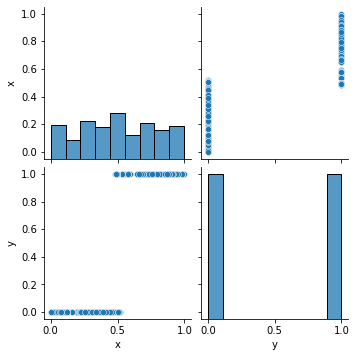

In [6]:
sns.pairplot(df)


The data is trained with a logistic regression model from sklearn. 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


# No data drift, no model drift
The first case is when 0.< x < 0.48 for every element `x` in `X_test`. There is no data drift since x is between 0 and 1. As stated earlier, the model can be expected to be highly accurate here. While monitoring, if the scoring jobs are in this range, the mat package should not observe any data drift or model drift. 

In [9]:
X_test = X[0:10]
print(X_test)
y_test = y[0:10]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

[[0.47866747]
 [0.25861549]
 [0.25350433]
 [0.01690075]
 [0.06437454]
 [0.20802378]
 [0.43956347]
 [0.39518413]
 [0.32276348]
 [0.19440808]]
Accuracy of logistic regression classifier on test set: 1.00


# Data drift not detected but model drift detected
The second case is when we take some elements from the aberration space as well for `X_test`. It is difficult to detect data drift in this case using the standard data drift metrics (ex. min, max, mean etc). A sophisticated data drift model is required to detect data drift in this case. The model is expected to fail here since there are few training samples in this region unless the model was overfit.  While monitoring, if the scoring jobs are in this range, the mat package should not observe any data drift but send an alert for model drift. 


In [9]:
X_test = X[N-7:N+7+N_aber:2]
print(X_test)
y_test = y[N-7:N+7+N_aber:2]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

[[0.22553833]
 [0.30988068]
 [0.33961185]
 [0.39078233]
 [0.51895069]
 [0.51977669]
 [0.5144164 ]
 [0.5043754 ]
 [0.50185374]
 [0.84608919]
 [0.91816545]
 [0.91109078]]
Accuracy of logistic regression classifier on test set: 0.75


# Data drift exists but no model drift
The third case is when `1.0 < x < 1.1` for every element `x` in `X_test`. There is data drift in this case since `x` is between 0 and 1 in the training set. Based on the trained model, it is reasonable to expect that any value of `x > 1` will result in `y = 1`. So, in this case if the observations for the target variable are also 1, there is no model drift.  While monitoring, if the scoring jobs are in this range and observations are 1 for the target variable, the mat package should alert for data drift but not for model drift. 

In [10]:
win_x = np.random.uniform(1.0,1.1, N_aber)
X_test = win_x.reshape(-1,1)
y_test = np.empty(N_aber)
y_test.fill(1)
print(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

[[1.09600212]
 [1.09302902]
 [1.05804199]
 [1.05965114]
 [1.01564412]
 [1.02386053]
 [1.0415256 ]
 [1.01075394]
 [1.03348371]
 [1.0176866 ]]
Accuracy of logistic regression classifier on test set: 1.00


# Data drift exists and model drift exists 
The fourth case is when `1.1 < x < 1.2` for every element `x` in `X_test`. There is data drift in this case since `x` is between 0 and 1 in the training set. Based on the trained model, it is reasonable to expect that any value of `x > 1` will result in `y = 1`. So, in this case if the observations for the target variable are 0, there is model drift. While monitoring, if the scoring jobs are in this range and observations are 0 for the target variable, the mat package should alert for data drift as well as model drift.



In [11]:
win_x = np.random.uniform(1.1,1.2, N_aber)
X_test = win_x.reshape(-1,1)
y_test = np.empty(N_aber)
y_test.fill(0)
print(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

[[1.12509623]
 [1.14142557]
 [1.17750409]
 [1.14368787]
 [1.14823627]
 [1.16904314]
 [1.10550578]
 [1.13891995]
 [1.18960168]
 [1.12418731]]
Accuracy of logistic regression classifier on test set: 0.00


# Concept drift
The fifth case is when the relationship of the target variable with the feature changes. For example, if in the future, the target variable `y` is observed to be 1 instead of 0 for `x < 0.48` then the current model becomes obsolete.   

In [12]:
X_test = X[0:10]
print(X_test)
y_test = np.empty(N_aber)
y_test.fill(1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

[[0.19088447]
 [0.04598682]
 [0.23920322]
 [0.04776665]
 [0.24169188]
 [0.28626224]
 [0.31579585]
 [0.4004189 ]
 [0.36521872]
 [0.19987849]]
Accuracy of logistic regression classifier on test set: 0.00
